# Optimization

In the field of optimal control, minimization algorithms are used to search for
global minima of cost functions. In the case of quantum computing the cost
function is often the aforementioned quantum fidelity and the control
parameters are usually pulse amplitudes.

Lets consider the previous example:


In [1]:
import numpy as np

from qsim.matrix import DenseOperator
from qsim.solver_algorithms import SchroedingerSolver
from qsim.cost_functions import OperationInfidelity


sigma_x = DenseOperator(np.asarray([[0, 1], [1, 0]]))
sigma_y = DenseOperator(np.asarray([[0, -1j], [1j, 0]]))
sigma_z = DenseOperator(np.asarray([[1, 0], [0, -1]]))
zero_matrix = DenseOperator(np.asarray([[0, 0], [0, 0]]))

delta_omega = 0

h_ctrl = [.5 * sigma_x, .5 * sigma_y]
h_drift = [delta_omega * .5 * sigma_z]

n_time_steps = 5
total_time = 1

time_steps = (total_time / n_time_steps) * np.ones((n_time_steps, ))

control_amplitudes = np.zeros((n_time_steps, len(h_ctrl)))
control_amplitudes[:, 0] = np.pi

solver = SchroedingerSolver(
    h_drift=h_drift * n_time_steps,
    h_ctrl=h_ctrl,
    tau=time_steps
)
solver.set_optimization_parameters(0 * control_amplitudes)

entanglement_infidelity = OperationInfidelity(
    solver=solver,
    target=sigma_x
)

The Simulator class defines an interface between the simulation and the
optimization algorithm.

In [2]:
from qsim.simulator import Simulator

simulator = Simulator(
    solvers=[solver, ],
    cost_fktns=[entanglement_infidelity, ]
)

The actual optimization algorithm is controlled by the class Optimizer. Let's
use the least squares optimization of scipy.

In [3]:
from qsim.optimize import LeastSquaresOptimizer

termination_conditions = {
    "min_gradient_norm": 1e-15,
    "min_cost_gain": 1e-15,
    "max_wall_time": 30.0,
    "max_cost_func_calls": 1e6,
    "max_iterations": 100,
    "min_amplitude_change": 1e-8
}

upper_bounds = 2 * np.pi * np.ones((len(h_ctrl) * n_time_steps, ))
lower_bounds = -1 * upper_bounds

optimizer = LeastSquaresOptimizer(
    system_simulator=simulator,
    termination_cond=termination_conditions,
    save_intermediary_steps=True,
    bounds=[lower_bounds, upper_bounds]
)

The bounds mark the range in which the optimization algorithm shall search for
an optimum. As initial values, we use a random pulse.

In [ ]:
initial_pulse = np.pi * np.random.rand(n_time_steps, len(h_ctrl))

result = optimizer.run_optimization(initial_control_amplitudes=initial_pulse)

Next we initialize a data container to store the information gained in the
optimization. The DataContainer class is instantiated with a storage path
and file name, where the data can be stored.


In [4]:
from qsim.data_container import DataContainer
from qsim.analyser import Analyser

data_container = DataContainer(
    storage_path=r'..\..\..\temp',
    file_name="File Name"
)

data_container.append_optim_result(optim_result=result)
analyser = Analyser(data=data_container)

The Analyser gives access to some convenience functions to plot the the cost
function evaluations during the optimization run.


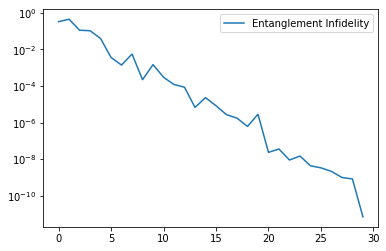

In [5]:
analyser.plot_costs()

In the plotted costs, we can observe the expected linear convergence for
newton-like optimization algorithms.

The Data container allows also to pickle the gathered data for later analysis.


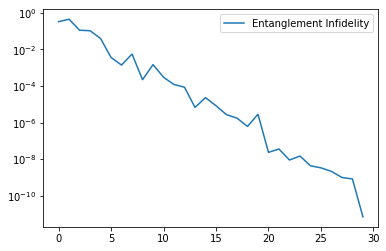

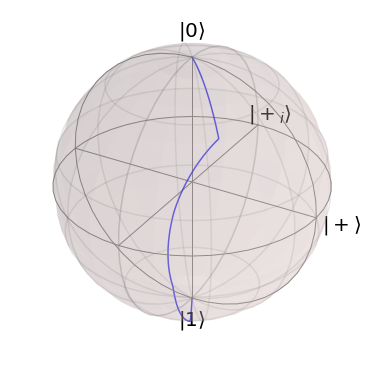

In [10]:
data_container.to_pickle()
loaded_data = DataContainer.from_pickle(r'..\..\..\temp\File Name')

analyser = Analyser(loaded_data)
analyser.plot_costs()
solver.set_optimization_parameters(loaded_data.final_parameters[0])
solver.plot_bloch_sphere()